In [15]:
import os
import re
import pickle
from dotenv import load_dotenv
from tqdm import tqdm
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
from tester import Tester

In [2]:
BASE_MODEL = "meta-llama/Llama-3.2-1B"
PROJECT_NAME = "pricer"
HF_USER = "Strider221B"

In [3]:
RUN_NAME = "2025-02-02_13.26.22"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = None # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"
QUANT_4_BIT = True

In [5]:
load_dotenv()
hf_token = os.getenv('HF_TOKEN_WR')
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [6]:
with open('./../data/app_test_dataset.pkl', 'rb') as f:
    test = pickle.load(f)

In [7]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [8]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4")

In [9]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

In [10]:
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

adapter_config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

In [11]:
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 1039.3 MB


In [12]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

In [13]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [14]:
top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

1: Guess: $12.28 Truth: $26.97 Error: $14.69 SLE: 0.55 Item: Discount Parts Direc...
2: Guess: $18.00 Truth: $36.99 Error: $18.99 SLE: 0.48 Item: BestRec Dryer Vent H...
3: Guess: $46.88 Truth: $41.33 Error: $5.55 SLE: 0.02 Item: Fuxury 12 Inch Impul...
4: Guess: $12.22 Truth: $45.02 Error: $32.80 SLE: 1.56 Item: Compatible Dryer Hea...
5: Guess: $15.16 Truth: $13.97 Error: $1.19 SLE: 0.01 Item: 694089 Dryer Blower ...
6: Guess: $12.30 Truth: $55.65 Error: $43.35 SLE: 2.10 Item: Compatible with Whir...
7: Guess: $8.41 Truth: $20.99 Error: $12.58 SLE: 0.72 Item: Replacement Aluminum...
8: Guess: $12.33 Truth: $30.68 Error: $18.35 SLE: 0.75 Item: Lifetime Appliance P...
9: Guess: $14.61 Truth: $57.99 Error: $43.38 SLE: 1.77 Item: OEM LG Refrigerator ...
10: Guess: $12.08 Truth: $8.99 Error: $3.09 SLE: 0.07 Item: Dryer Lint Filter Re...
11: Guess: $12.40 Truth: $25.95 Error: $13.55 SLE: 0.49 Item: FAMCO Dryer Vent Cov...
12: Guess: $6.97 Truth: $13.99 Error: $7.02 SLE: 0.40 Item: HIFROM H

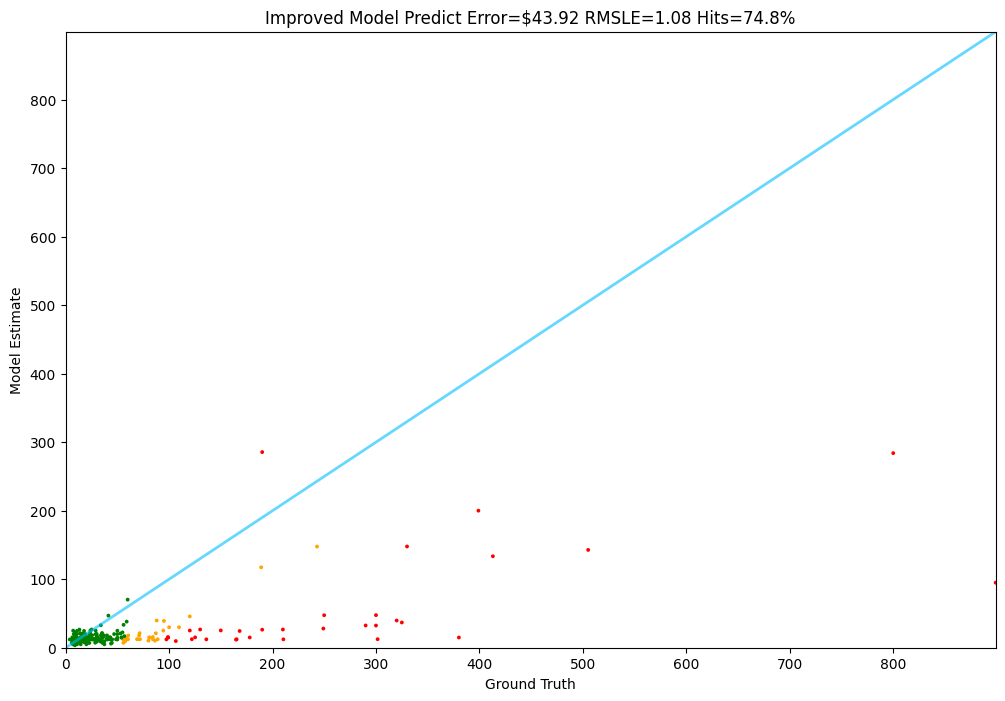

In [16]:
Tester.test(improved_model_predict, test)